# Balloon HDF5 Event Reader

This simple notebook shows how we can read example waveforms from an experiment consisting of antennas dangling from a balloon above Antarctica. It will illustrate how these could be turned into images for use in machine learning training.


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import math
import h5py


In [2]:
run=130
f = h5py.File('flight2016/hdf5/run'+str(run)+'/event'+str(run)+'.hdf5')
rungr=f['run'+str(run)]
calgr=f['calib']
fhead = h5py.File('flight2016/hdf5/run'+str(run)+'/header'+str(run)+'.hdf5')
headgr = fhead['run'+str(run)]
print("headgr.keys()",headgr.keys())

headgr.keys() <KeysViewHDF5 ['altitude', 'attFlag', 'brms', 'distToWais', 'eventNumber', 'goodTimeFlag', 'heading', 'isWAIS', 'l3TrigPattern', 'l3TrigPatternH', 'latitude', 'longitude', 'mrms', 'phiTrigMask', 'phiTrigMaskH', 'pitch', 'priority', 'roll', 'triggerTime', 'triggerTimeNs']>


In [3]:
print(calgr.keys())
timeValues=np.array(calgr['timeValues'])
print('timeValues.shape',timeValues.shape)
#print(rungr.keys())

<KeysViewHDF5 ['timeValues']>
timeValues.shape (12, 4, 774)


In [21]:
#This gets the first event in the file
firstev="ev_"+str(headgr['eventNumber'][:][0])
print("First event directory",firstev)

#This gets the first calibration pulser event in the file
isWAIS=headgr['isWAIS'][:]
#print(headgr['eventNumber'][:][isWAIS])
firstwais="ev_"+str(headgr['eventNumber'][:][isWAIS][0])
firstnotwais="ev_"+str(headgr['eventNumber'][:][1-isWAIS][0])
print("First calibration event",firstwais)

#firstev=list(rungr.keys())[100]  #This is very slow as it lists all the keys... perhaps need to reorder things
evgr=rungr[firstwais]
print(evgr.keys())



def getTimesAndMillivolts(evgr,timeValues):
    adcOffset=np.array(evgr['data'].attrs['adcOffset'])
    mvScale=np.array(evgr['data'].attrs['mvScale'])
    timeOffset=np.array(evgr['data'].attrs['timeOffset'])
    timeScale=np.array(evgr['data'].attrs['timeScale'])
    validTimeInds=np.array(evgr['data'].attrs['validTimeInds'])
    chips=np.array(evgr['data'].attrs['chips'])
    data=np.array(evgr['data'])
    adcOffset= np.reshape(adcOffset, (adcOffset.shape[0], adcOffset.shape[1],-1))
    mvScale= np.reshape(mvScale, (mvScale.shape[0], mvScale.shape[1],-1))
    timeOffset= np.reshape(timeOffset, (timeOffset.shape[0], timeOffset.shape[1],-1))
    timeScale= np.reshape(timeScale, (timeScale.shape[0], timeScale.shape[1],-1))
    
    print(chips)
    data=mvScale*(data-adcOffset)
    times=np.zeros((12,9,250))  #Times for all the waveforms
    N=np.zeros((12,9),dtype=int)
    for surf in range(12):
        for chan in range(9):
            times[surf][chan][0:validTimeInds[surf][1]-validTimeInds[surf][0]]=timeValues[surf][chips[surf]][validTimeInds[surf][0]:validTimeInds[surf][1]]
            times[surf][chan][:]=times[surf][chan][:]-times[surf][chan][0]
            N[surf][chan]=validTimeInds[surf][1]-validTimeInds[surf][0]
  
    #times=(times*timeScale)+timeOffset
    return N,times,data




First event directory ev_22896101
First calibration event ev_22896178
<KeysViewHDF5 ['data']>


[1 1 1 1 1 1 1 1 1 1 1 1]


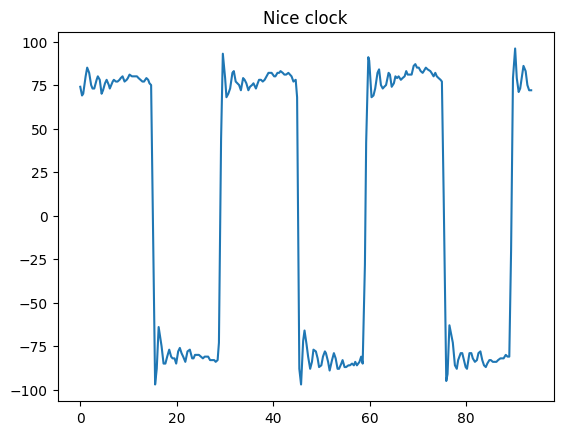

In [5]:

N,times,data=getTimesAndMillivolts(evgr,timeValues)

def getSurfChanTD(N,times,data,surf,chan):
    return times[surf][chan][0:N[surf][chan]],data[surf][chan][0:N[surf][chan]]


fig,ax = plt.subplots()
ax.set_title("Nice clock")
T,D=getSurfChanTD(N,times,data,0,8)
ax.plot(T,D)

In [6]:
print(evgr['data'].attrs.keys())
print(evgr['data'].attrs['distToWais'])



<KeysViewHDF5 ['adcOffset', 'altitude', 'attFlag', 'brms', 'chips', 'distToWais', 'eventNumber', 'goodTimeFlag', 'heading', 'l3TrigPattern', 'l3TrigPatternH', 'latitude', 'longitude', 'mrms', 'mvScale', 'phiTrigMask', 'phiTrigMaskH', 'pitch', 'priority', 'roll', 'timeOffset', 'timeScale', 'triggerTime', 'triggerTimeNs', 'validTimeInds']>
inf


In [8]:
import antgeom
myGeom=antgeom.AntGeom()
print(myGeom.antToSurfMap)
print(myGeom.vAntToChan)

[11  5 10  4 11  4 10  5 11  5 10  4 11  4 10  5  9  3  8  2  8  3  9  2
  9  3  8  2  8  3  9  2  6  0  7  1  6  1  7  0  6  0  7  1  6  1  7  0]
[3 1 3 5 1 3 1 3 2 0 2 0 0 2 0 2 1 3 1 3 3 1 3 1 0 2 0 2 2 0 2 0 3 1 3 1 1
 3 1 3 2 0 2 0 0 2 0 2]


In [22]:

Ncal,caltimes,caldata=getTimesAndMillivolts(rungr[firstwais],timeValues)
Nnocal,nocaltimes,nocaldata=getTimesAndMillivolts(rungr[firstnotwais],timeValues)

print(times.shape)
vImageCal=np.zeros((48,250))
tImageCal=np.zeros((48,250))
for row in range(48):
    vImageCal[row]=caldata[myGeom.antToSurfMap[row]][myGeom.vAntToChan[row]]
    tImageCal[row]=caltimes[myGeom.antToSurfMap[row]][myGeom.vAntToChan[row]]


vImageNoCal=np.zeros((48,250))
tImageNoCal=np.zeros((48,250))
for row in range(48):
    vImageNoCal[row]=nocaldata[myGeom.antToSurfMap[row]][myGeom.vAntToChan[row]]
    tImageNoCal[row]=nocaltimes[myGeom.antToSurfMap[row]][myGeom.vAntToChan[row]]



[1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1]
(12, 9, 250)


Text(0.5, 0.95, 'Calibration Event')

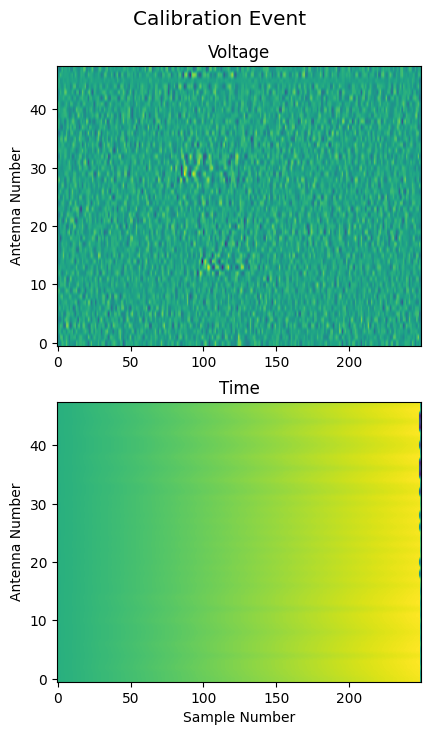

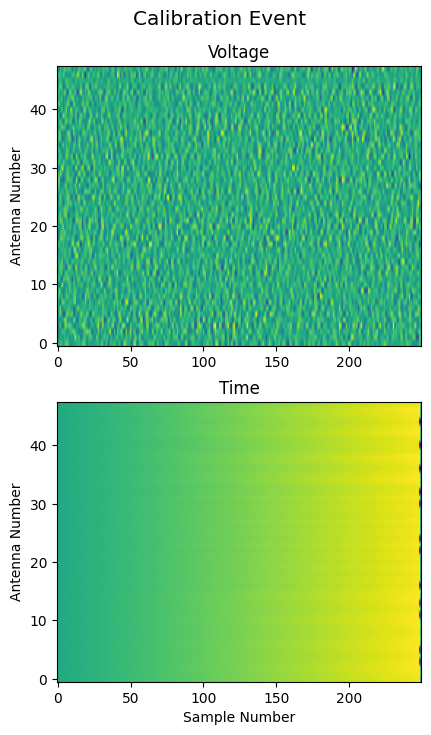

In [30]:
fig,ax = plt.subplots(2,1,figsize=(16,8))
ax[0].imshow(vImageCal,aspect=4,origin='lower')
#ax[0].set_xlabel("Sample Number")
ax[0].set_ylabel("Antenna Number")
ax[0].set_title("Voltage")
ax[1].imshow(tImageCal,aspect=4,origin='lower')
ax[1].set_xlabel("Sample Number")
ax[1].set_ylabel("Antenna Number")
ax[1].set_title("Time")
fig.suptitle("Calibration Event",fontsize="x-large",y=0.95)

fig,ax = plt.subplots(2,1,figsize=(16,8))
ax[0].imshow(vImageNoCal,aspect=4,origin='lower')
#ax[0].set_xlabel("Sample Number")
ax[0].set_ylabel("Antenna Number")
ax[0].set_title("Voltage")
ax[1].imshow(tImageNoCal,aspect=4,origin='lower')
ax[1].set_xlabel("Sample Number")
ax[1].set_ylabel("Antenna Number")
ax[1].set_title("Time")
fig.suptitle("Calibration Event",fontsize="x-large",y=0.95)
